<h1 style="color:Red;">1. Loading and observing Data</h1><hr>


In [442]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from IPython.core.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.special import boxcox1p
from sklearn.metrics import accuracy_score

In [443]:
#Get the train dataset
flight_train = pd.read_excel("Data_Train.xlsx")
#Get the test dataset
flight_pred = pd.read_excel("Test_set.xlsx")
flight_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [444]:
# Source to Destination number of flights
pd.crosstab(flight_train['Source'],flight_train['Destination'])

Destination,Banglore,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
Source,,,,,,
Banglore,0,0,1265,0,0,932
Chennai,0,0,0,0,381,0
Delhi,0,4537,0,0,0,0
Kolkata,2871,0,0,0,0,0
Mumbai,0,0,0,697,0,0


In [445]:
#Check for null values in the dataset and drop the null columns
flight_train.isnull().sum()
null_columns=flight_train.columns[flight_train.isnull().any()]
flight_train.dropna(inplace=True)

# Select duplicate rows except first occurrence based on all columns
duplicateRows = flight_train[flight_train.duplicated()]
print(duplicateRows)
flight_train.drop_duplicates(keep='first',inplace=True)

           Airline Date_of_Journey    Source Destination  \
683    Jet Airways       1/06/2019     Delhi      Cochin   
1061     Air India      21/05/2019     Delhi      Cochin   
1348     Air India      18/05/2019     Delhi      Cochin   
1418   Jet Airways       6/06/2019     Delhi      Cochin   
1674        IndiGo      24/03/2019  Banglore   New Delhi   
...            ...             ...       ...         ...   
10594  Jet Airways      27/06/2019     Delhi      Cochin   
10616  Jet Airways       1/06/2019     Delhi      Cochin   
10634  Jet Airways       6/06/2019     Delhi      Cochin   
10672  Jet Airways      27/06/2019     Delhi      Cochin   
10673  Jet Airways      27/05/2019     Delhi      Cochin   

                       Route Dep_Time  Arrival_Time Duration Total_Stops  \
683    DEL → NAG → BOM → COK    14:35  04:25 02 Jun  13h 50m     2 stops   
1061   DEL → GOI → BOM → COK    22:00  19:15 22 May  21h 15m     2 stops   
1348   DEL → HYD → BOM → COK    17:15  19:15 19 May

In [446]:
#Number of passangers travelling with the different airlines
flight_train['Airline'].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

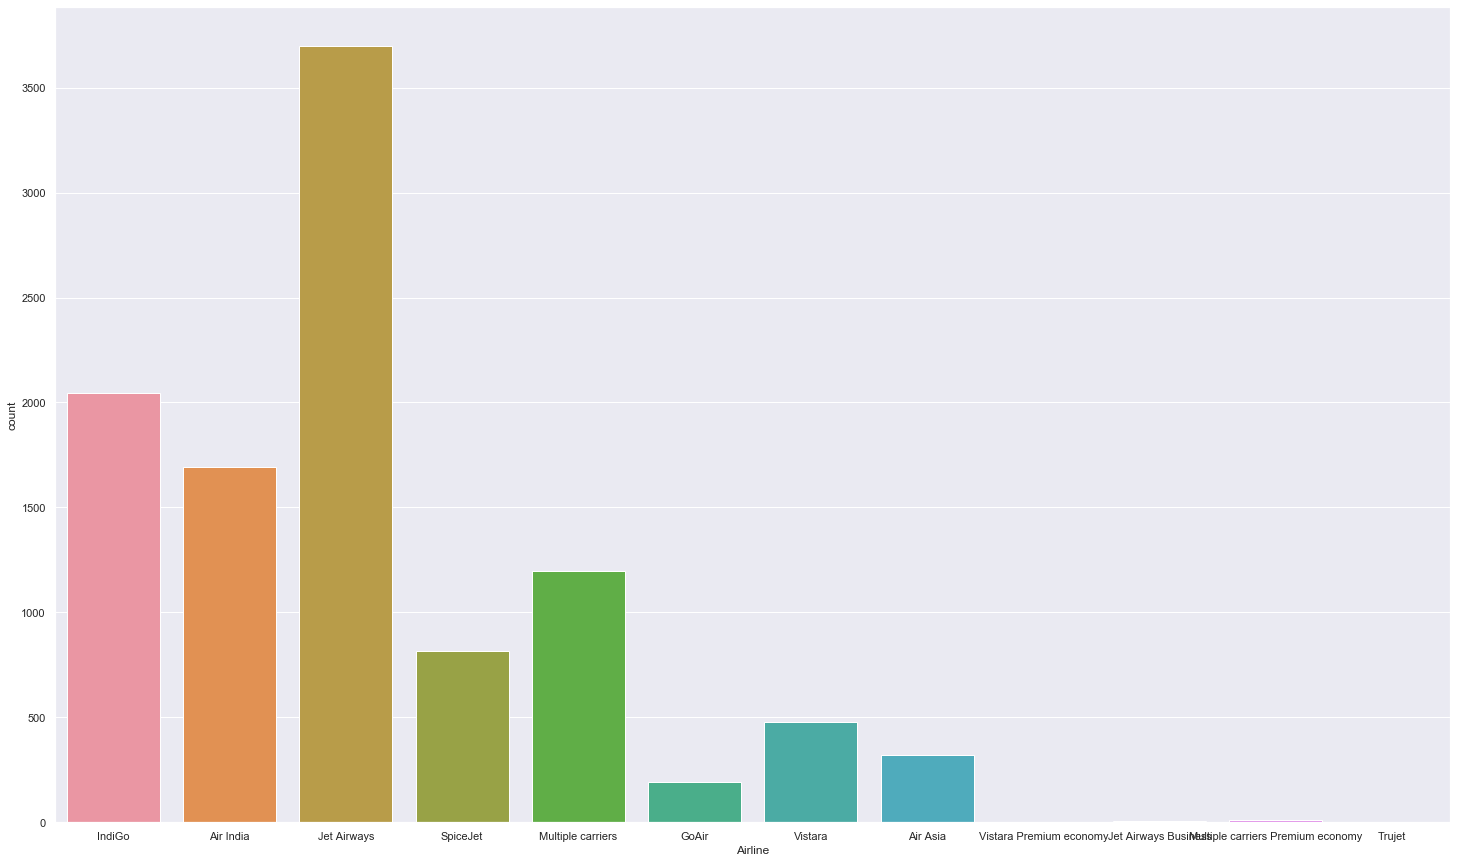

In [447]:
# Graphical representation
display(HTML('<h3 style="color:Orange;">Graph of various airlines</h3>'))
sns.set(rc={'figure.figsize':(25,15)})
sns.countplot(flight_train['Airline'])

## From below graph we can merge the last 6 airlines into one as "others" as these have very little significant information

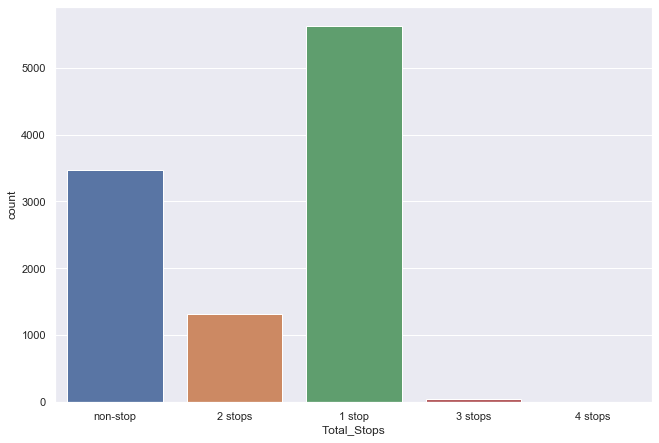

In [448]:
# Graph of people travelling based on Number of stops
display(HTML('<hr><hr><h3 style="color:orange;">Graph of people travelling based on Number of stops</h3>'))
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.countplot(flight_train['Total_Stops'])

<h1 style="color:Red;">2. Data Transformation</h1><hr>


In [449]:
# Replacing the total stops by their corresponding numerical values.  
flight_train.Total_Stops.replace(['non-stop','1 stop', '2 stops', '3 stops', '4 stops'], [ 0, 1, 2, 3, 4], inplace=True)
flight_pred.Total_Stops.replace([ 'non-stop', '1 stop','2 stops', '3 stops', '4 stops'], [ 0, 1, 2, 3, 4], inplace=True)
flight_train["Total_Stops"] = flight_train["Total_Stops"].astype(int)
flight_pred["Total_Stops"] = flight_pred["Total_Stops"].astype(int)

In [450]:
#Separating day and month from "Date of Journey" Column

# For Training Data
flight_train["Day_Of_Journey"] = pd.to_datetime(flight_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day
flight_train["Day_of_Week"] = pd.to_datetime(flight_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
flight_train["Month_of_Journey"] = pd.to_datetime(flight_train["Date_of_Journey"], format = '%d/%m/%Y').dt.month
flight_train["isWeekend"] = ((pd.to_datetime(flight_train["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)

# For Testing Data
flight_pred["Day_Of_Journey"] = pd.to_datetime(flight_pred["Date_of_Journey"], format = '%d/%m/%Y').dt.day
flight_pred["Day_of_Week"] = pd.to_datetime(flight_pred["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
flight_pred["Month_of_Journey"] = pd.to_datetime(flight_pred["Date_of_Journey"], format = '%d/%m/%Y').dt.month
flight_pred["isWeekend"] = ((pd.to_datetime(flight_pred["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)

# Drop the column "Date of Journey"
flight_train.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)
flight_pred.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)

In [451]:
# We ahve duration which is in "hh.mm" format.
flight_train["Duration"]

0        2h 50m
1        7h 25m
2           19h
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680        3h
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10462, dtype: object

In [452]:
#Convert the duration into total minutes by multiplying hours with 60 and adding it to minutes. 

dur_min=  flight_train['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
flight_train['Duration_minutes']=dur_min
flight_train.drop(["Duration"], axis=1, inplace = True)

dur_min=  flight_pred['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
flight_pred['Duration_minutes']=dur_min
flight_pred.drop(["Duration"], axis=1, inplace = True)


In [453]:
flight_train.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Day_Of_Journey,Day_of_Week,Month_of_Journey,isWeekend,Duration_minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,0,No info,3897,24,Sunday,3,1,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2,No info,7662,1,Wednesday,5,0,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,2,No info,13882,9,Sunday,6,1,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1,No info,6218,12,Sunday,5,1,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1,No info,13302,1,Friday,3,0,285


In [454]:
#Looking into additional information column for duplicate values
print("Training data\n",flight_train["Additional_Info"].value_counts())
print("-------------------------------------------------")
print("\nPrediction data:\n",flight_pred["Additional_Info"].value_counts())

Training data
 No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
Red-eye flight                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64
-------------------------------------------------

Prediction data:
 No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Change airports                    1
Business class                     1
1 Long layover                     1
Name: Additional_Info, dtype: int64


In [455]:
# No info and No Info are repeated in above data so we merge both of the data by replacing one quantity
flight_train["Additional_Info"] = flight_train["Additional_Info"].replace({'No Info': 'No info'})
flight_pred["Additional_Info"].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Change airports                    1
Business class                     1
1 Long layover                     1
Name: Additional_Info, dtype: int64

In [456]:
#Cleaning Departure and Arrival Times using Datetime Library

# Training Set
flight_train['Depart_Time_Hour'] = pd.to_datetime(flight_train.Dep_Time).dt.hour
flight_train['Depart_Time_Minutes'] = pd.to_datetime(flight_train.Dep_Time).dt.minute
flight_train.drop(labels = 'Dep_Time', axis = 1, inplace = True)
flight_train['Arr_Time_Hour'] = pd.to_datetime(flight_train.Arrival_Time).dt.hour
flight_train['Arr_Time_Minutes'] = pd.to_datetime(flight_train.Arrival_Time).dt.minute
flight_train.drop(labels = 'Arrival_Time', axis = 1, inplace = True)

# Prediction Set
flight_pred['Depart_Time_Hour'] = pd.to_datetime(flight_pred.Dep_Time).dt.hour
flight_pred['Depart_Time_Minutes'] = pd.to_datetime(flight_pred.Dep_Time).dt.minute
flight_pred.drop(labels = 'Dep_Time', axis = 1, inplace = True)
flight_pred['Arr_Time_Hour'] = pd.to_datetime(flight_pred.Arrival_Time).dt.hour
flight_pred['Arr_Time_Minutes'] = pd.to_datetime(flight_pred.Arrival_Time).dt.minute
flight_pred.drop(labels = 'Arrival_Time', axis = 1, inplace = True)

In [457]:
# We separated fetures and prediction feature as X and y respectively

X = flight_train.drop(["Price"], axis=1)
y = np.log1p(flight_train["Price"])

# For prediction data we will get the prices using the model which we are going to use
X_to_predict = flight_pred
X.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Day_Of_Journey,Day_of_Week,Month_of_Journey,isWeekend,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,No info,24,Sunday,3,1,170,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,1,Wednesday,5,0,445,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,9,Sunday,6,1,1140,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info,12,Sunday,5,1,325,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,No info,1,Friday,3,0,285,16,50,21,35


<h1 style="color:Red;"> 3. Data Encoding</h1><hr>


In [458]:
#Separate categorical and numerical columns in dataframe
# For Training Data
X_categorical = X.select_dtypes(exclude=['int', 'float'])
X_numerical = X.select_dtypes(include=['int', 'float'])


# For Testing Data
X_to_predict_categorical = X_to_predict.select_dtypes(exclude=['int', 'float'])
X_to_predict_numerical = X_to_predict.select_dtypes(include=['int', 'float'])

#Create copy for plotting graphs
X_numerical_copy = X_numerical.copy()
X_category_copy = X_categorical.copy()

In [459]:
#Using Label encode to convert categorical data into numerical data

from sklearn.preprocessing import LabelEncoder
X_categorical = X_categorical.apply(LabelEncoder().fit_transform)
X_to_predict_categorical = X_to_predict_categorical.apply(LabelEncoder().fit_transform)
X_categorical.head()

,Airline,Source,Destination,Route,Additional_Info,Day_Of_Journey,Day_of_Week,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,3,0,5,18,7,8,3,0,13,22,4,1,2
1,1,3,0,84,7,0,6,2,65,5,10,13,3
2,4,2,1,118,7,3,3,3,202,9,5,4,5
3,3,3,0,91,7,4,3,2,41,18,1,23,6
4,3,0,5,29,7,0,0,0,33,16,10,21,7


In [460]:
#Merge categorical and numerical columns back into respective X and X_to_predict
X = pd.concat([X_categorical, X_numerical], axis=1)
X_to_predict = pd.concat([X_to_predict_categorical, X_to_predict_numerical], axis=1)

In [461]:
X_to_predict.head()

,Airline,Source,Destination,Route,Additional_Info,Day_Of_Journey,Day_of_Week,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes,Total_Stops,isWeekend
0,4,2,1,76,5,2,4,3,103,17,6,4,5,1,0
1,3,3,0,65,5,4,3,2,21,6,4,10,4,1,1
2,4,2,1,76,3,7,5,2,236,19,3,19,0,1,0
3,6,2,1,76,5,7,5,2,128,8,0,21,0,1,0
4,0,0,2,16,5,8,1,3,13,23,11,2,9,0,0


In [462]:
X.head()

,Airline,Source,Destination,Route,Additional_Info,Day_Of_Journey,Day_of_Week,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes,Total_Stops,isWeekend
0,3,0,5,18,7,8,3,0,13,22,4,1,2,0,1
1,1,3,0,84,7,0,6,2,65,5,10,13,3,2,0
2,4,2,1,118,7,3,3,3,202,9,5,4,5,2,1
3,3,3,0,91,7,4,3,2,41,18,1,23,6,1,1
4,3,0,5,29,7,0,0,0,33,16,10,21,7,1,0


<li><h1 style="color:Red;">4. Applying Models</h1><hr>


<ul><h2 style="color:Orange;">1. Linear Regression
    </h2></ul></li>

In [463]:
# Linear Regression

from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=20, test_size=0.3)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('R Squared accuracy', metrics.r2_score(y_test, y_pred))    
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R Squared accuracy 0.5619554626189832
Mean Squared Error: 0.11709386228033751
Root Mean Squared Error: 0.3421898044657928


<ul><h2 style="color:Orange;"> 2.Bayesian Ridge Model </h2></ul></li>

In [464]:
# Baysian Regression
from sklearn.linear_model import BayesianRidge

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=20, test_size=0.3)
regressor = BayesianRidge() 
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('R Squared accuracy', metrics.r2_score(y_test, y_pred))    
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R Squared accuracy 0.5618514838412096
Mean Squared Error: 0.11712165688943704
Root Mean Squared Error: 0.34223041490995076


<ul><h2 style="color:Orange;"> 3.Random Forest Regressor </h2></ul></li>

In [465]:
#Random forest regressor

from sklearn.ensemble import RandomForestRegressor
def randomForestRegression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print('R Squared accuracy', metrics.r2_score(y_test, y_pred))    
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return rf
randomForestModel = randomForestRegression(X,y)

c:\users\shubh\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R Squared accuracy 0.9221839526488532
Mean Squared Error: 0.020505931135038562
Root Mean Squared Error: 0.14319892155682795




List of the features according to the importance:


                     importance
Duration_minutes       0.603921
Airline                0.094861
Additional_Info        0.051064
Day_Of_Journey         0.047520
Total_Stops            0.039158
Month_of_Journey       0.036089
Route                  0.021709
Destination            0.017657
Depart_Time_Minutes    0.017373
Arr_Time_Hour          0.015758
Day_of_Week            0.015640
Depart_Time_Hour       0.014872
Arr_Time_Minutes       0.013382
isWeekend              0.006028
Source                 0.004966



Graph of feature importance:


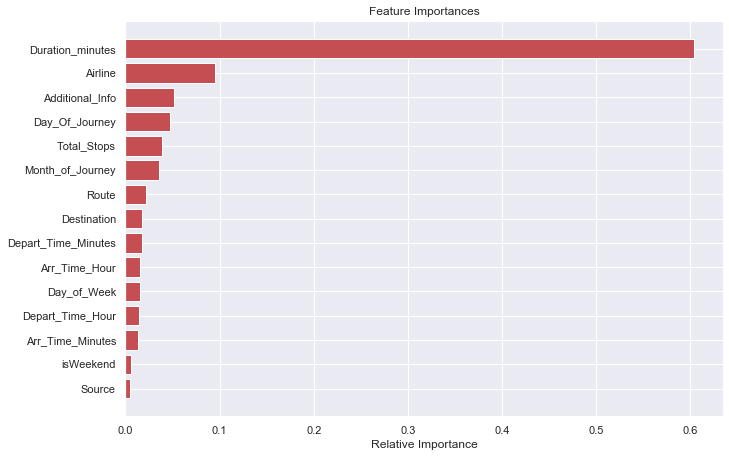

In [466]:
# Feature importances from a model

import matplotlib.pyplot as plt

imp_features= pd.DataFrame(randomForestModel.feature_importances_,index = X.columns, columns=['importance']).sort_values('importance',ascending=False)
print("\n\nList of the features according to the importance:\n\n")
print(imp_features)

# Graph of feature importance
print("\n\n\nGraph of feature importance:")
features = X.columns.tolist()
importances = randomForestModel.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[each] for each in indices])
plt.xlabel('Relative Importance')
plt.show()

# From below graph We can see "Duration" and "airline company" are most important features


<ul><h2 style="color:Orange;"> 4.XGB regressor Model </h2></ul></li>

In [467]:
#XGboost
from xgboost import XGBRegressor
def XGBRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    xgb = XGBRegressor(gamma=0.0468,learning_rate=0.04, max_depth=4, 
                             n_estimators=3000,reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print('R Squared accuracy', metrics.r2_score(y_test, y_pred))    
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return xgb
xgbRegressorModel = XGBRegressorModel(X,y)

c:\users\shubh\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R Squared accuracy 0.93676882082198
Mean Squared Error: 0.016662555474717945
Root Mean Squared Error: 0.12908352131359735




List of the features according to the importance:


                     importance
Duration_minutes       0.356766
Additional_Info        0.118991
Total_Stops            0.102547
Airline                0.077895
Day_Of_Journey         0.057801
Month_of_Journey       0.055432
Source                 0.041161
Destination            0.038630
Route                  0.030094
Day_of_Week            0.021783
Arr_Time_Hour          0.021548
Depart_Time_Hour       0.021247
isWeekend              0.019340
Depart_Time_Minutes    0.018705
Arr_Time_Minutes       0.018060



Graph of feature importance:


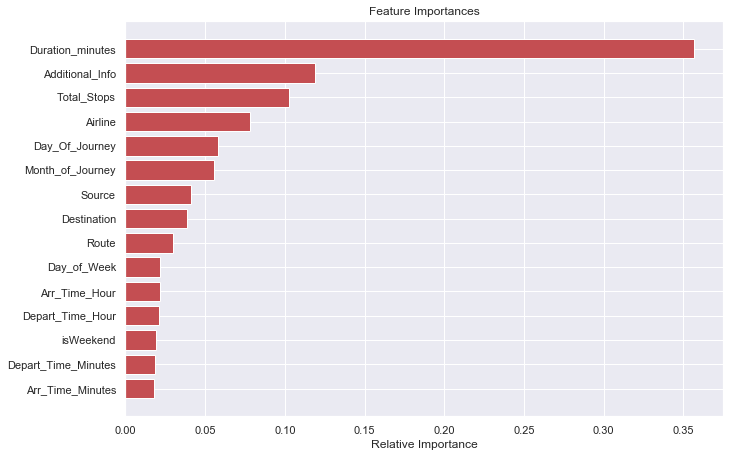

In [468]:
#Feature importances from "xgbRegressormodel" model
imp_features= pd.DataFrame(xgbRegressorModel.feature_importances_,index = X.columns, columns=['importance']).sort_values('importance',ascending=False)
print("\n\nList of the features according to the importance:\n\n")
print(imp_features)

# Graph of feature importance
print("\n\n\nGraph of feature importance:")
features = X.columns.tolist()
importances = xgbRegressorModel.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[each] for each in indices])
plt.xlabel('Relative Importance')
plt.show()

<ul><h2 style="color:Orange;"> 5.Gradien Boosting Regressor Model </h2></ul></li>

In [469]:
from sklearn.ensemble import GradientBoostingRegressor 

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
rf = GradientBoostingRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('R Squared accuracy', metrics.r2_score(y_test, y_pred))    
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


R Squared accuracy 0.8658591951991077
Mean Squared Error: 0.035348519993995936
Root Mean Squared Error: 0.18801202087631508


<li><h1 style="color:red;">5. Analyzing Performance of different models </h1></li>


<table>
  <tr>
    <th>Model</th>
    <th>R squared (Accuracy)</th>
    <th>RMSE</th>
  </tr>
  <tr>
    <td>Linear Regression</td>
    <td>0.561 </td>
    <td>0.342</td>
  </tr>
  <tr>
    <td>Bayesian Ridge Model</td>
    <td>0.561</td>
    <td>0.342</td>
  </tr>
  <tr>
    <td>Random Forest Regressor</td>
    <td>0.923 </td>
    <td>0.141</td>
  </tr>
  <tr>
    <td>XGB regressor Model </td>
    <td>0.936</td>
    <td>0.129</td>
  </tr>
  <tr>
    <td>Gradien Boosting Regressor Model</td>
    <td>0.865</td>
    <td>0.188</td>
  </tr>
</table>

<p> From the above table we can see that the accuracy of the XGB regressor is highest. Random Forest regression also does good job. Linear regression has lowest accuracy.
    <br>Hence, we are going to choose two highest performing models for the predicting the price of the flights.
    We are going to use the test data for this purpose on XGB regressor and Random Forest regression.


<li><h1 style="color:red;"> 6.Applying the highest performing models to predict the  prices </h1>

<ul><h2 style="color:orange;"> 1. Flight price prediction using XGB regressor </h2></ul>

In [474]:
xgb_pred = xgbRegressorModel.predict(X_to_predict)
print("Predicted price of the flight tickets:\n")
print(xgb_pred)

Predicted price of the flight tickets:

[9.147132 8.512387 9.498949 ... 9.294497 9.285075 8.935671]


<ul><h2 style="color:orange;"> 2. Flight Price prediction Random Forest regression </h2></ul>

In [476]:
rf_pred = rf.predict(X_to_predict)
print("predicted prices of the flight tickets: \n")
print(rf_pred)

predicted prices of the flight tickets: 

[9.22029102 8.53056938 9.3847581  ... 9.41625887 9.14952631 9.02203212]
